# Import the required libraries

This notebook uses 6 ML models:  
* CatBoost
* XGBoost
* Random Forest Tree
* Simple Decision Tree
* Lasso Regression
* Simple Linear Regression  

The used metrics are:  
* MAE
* SQRT

In [1]:
import datetime
import math
import os 
import time

from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error as sklearn_mae
from sklearn.metrics import mean_squared_error as sklearn_sqrt

import statsmodels.api as sm

import matplotlib.path as mpath
import matplotlib.patheffects as PathEffects
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc


np.set_printoptions(precision=3, suppress=True)

# Specify the data paths

Use only Sport5 dataset because it has the highest number of the data points with power metrics

In [2]:
root_dir = Path(os.getcwd())
data_dir = root_dir/Path("data")
dataset_5 = data_dir/Path("Sport5")

current_df_dir = dataset_5
csv_filename = 'cycling_data.csv'

Import the dataset and preprocess

In [3]:
df = pd.read_csv(current_df_dir/csv_filename, parse_dates = [2])

Assign an incremential cycling session ID and resample by 1 day

In [4]:
sessions = df.reset_index().rename({'index':'session_id'},axis=1)[['session_id','date']]
sessions = sessions.sort_values(by=['date'])
sessions = sessions.set_index('date')
sessions = sessions.resample('1D').first()

Create clusters of the races to group the days into the chunks with a delay less than 30 days

In [5]:
max_delay = 30
current_delay = max_delay
cluster_id = 0
clusters = []
reset = False
for i, row in sessions.iterrows():
    # if the row does not have any cycling data start counting the delay
    if np.isnan(row[0]):
        if current_delay > 0:
            current_delay -= 1
        else:
            # in the current delay is more than maximum specified delay reset it and change the cluster id
            reset = True
            current_delay = max_delay
            cluster_id += 1
        clusters.append(np.nan)
    else:
        clusters.append(cluster_id)
        if reset:
            current_delay = max_delay
            reset = False

Specify a race/training ration in a way that 60% of the time was given for the trainings

In [6]:
races_ratio = 0.6

Assign clusters to the working dataset, drop nan values and keep only those have at least 4 days. So, at least 3 training and at least 1 racing day

In [67]:
s = sessions.reset_index()
s['cluster'] = clusters
s.dropna(inplace=True)
s = s[s.cluster.map(s.cluster.value_counts()) > 3]

Assign categories: training or race

In [68]:
def divide_trainings_and_races(x):
    x['training_race'] = ''
    starting_point=math.ceil((len(x)*races_ratio))
    x.iloc[starting_point:]['training_race'] = 't'
    x.iloc[:starting_point]['training_race'] = 'r'
    return x

s = s.groupby(['cluster']).apply(divide_trainings_and_races)

Make data subsets

In [69]:
trainings = s[s['training_race']=='t']
races = s[s['training_race']=='r']

Create a working dataframe df_r that creates a cartesian product of the trainings and races.  
Then calculate race/training delay and normalise it
Finally, take the cycling session data from the original dataframe

In [70]:
if 'session_id' not in df.columns:
    df = df.reset_index().rename({'index':'session_id'},axis=1)
df_r = pd.merge(trainings, races, on='cluster', how='outer')
df_r['days_delay'] = df_r['date_x'] - df_r['date_y']

df_r['d_n'] = df_r.groupby('cluster')['days_delay'].transform(lambda x: (x - x.mean()) / x.std())
df_r = df_r.merge(df, left_on = 'session_id_x', right_on = 'session_id', suffixes=('_t','_r'))
df_r = df_r.merge(df, left_on = 'session_id_y', right_on = 'session_id', suffixes=('_t','_r'))

Specify the prediction features (obtained from the previous research)

In [71]:
features = [
    'd_n',
        'average_speed_t',
 'average_power_t',
#  'average_cadence_t',
 'average_heart_rate_t',
 'average_altitude_t',
 'high_altitude_distance_t',
 'high_altitude_time_t',
 'total_elevation_t',
 'total_calories_t',
 'total_work_t',
 'max_altitude_t',
 'bursts_n_t',
 'efforts_20m_t',
 'tempo_efforts_8m_t',
 'mmp_5m_0_t',
 'mmp_5m_1_t',
 'mmp_6m_0_t',
 'mmp_6m_1_t',
 'mmp_10m_0_t',
 'mmp_10m_1_t',
 'mmp_12m_0_t',
 'mmp_12m_1_t',
 'mmp_15m_0_t',
 'mmp_15m_1_t',
 'mmp_20m_0_t',
 'mmp_20m_1_t',
 'mmp_30m_0_t',
 'mmp_30m_1_t',
 'mmp_40m_0_t',
 'mmp_45m_0_t',
#  'average_cadence_r',
 'average_altitude_r',
 'high_altitude_distance_r',
 'total_elevation_r',
 'max_altitude_r'
]
predict_targets = ['mmp_5m_0_r','mmp_10m_0_r','mmp_15m_0_r','mmp_30m_0_r','mmp_45m_0_r']
exclude_vars = ['average_power_t','mmp_40m_0_t','mmp_45m_0_t','max_altitude_t','average_speed_t']
features2 = [x for x in features if x not in exclude_vars and '_1' not in x]

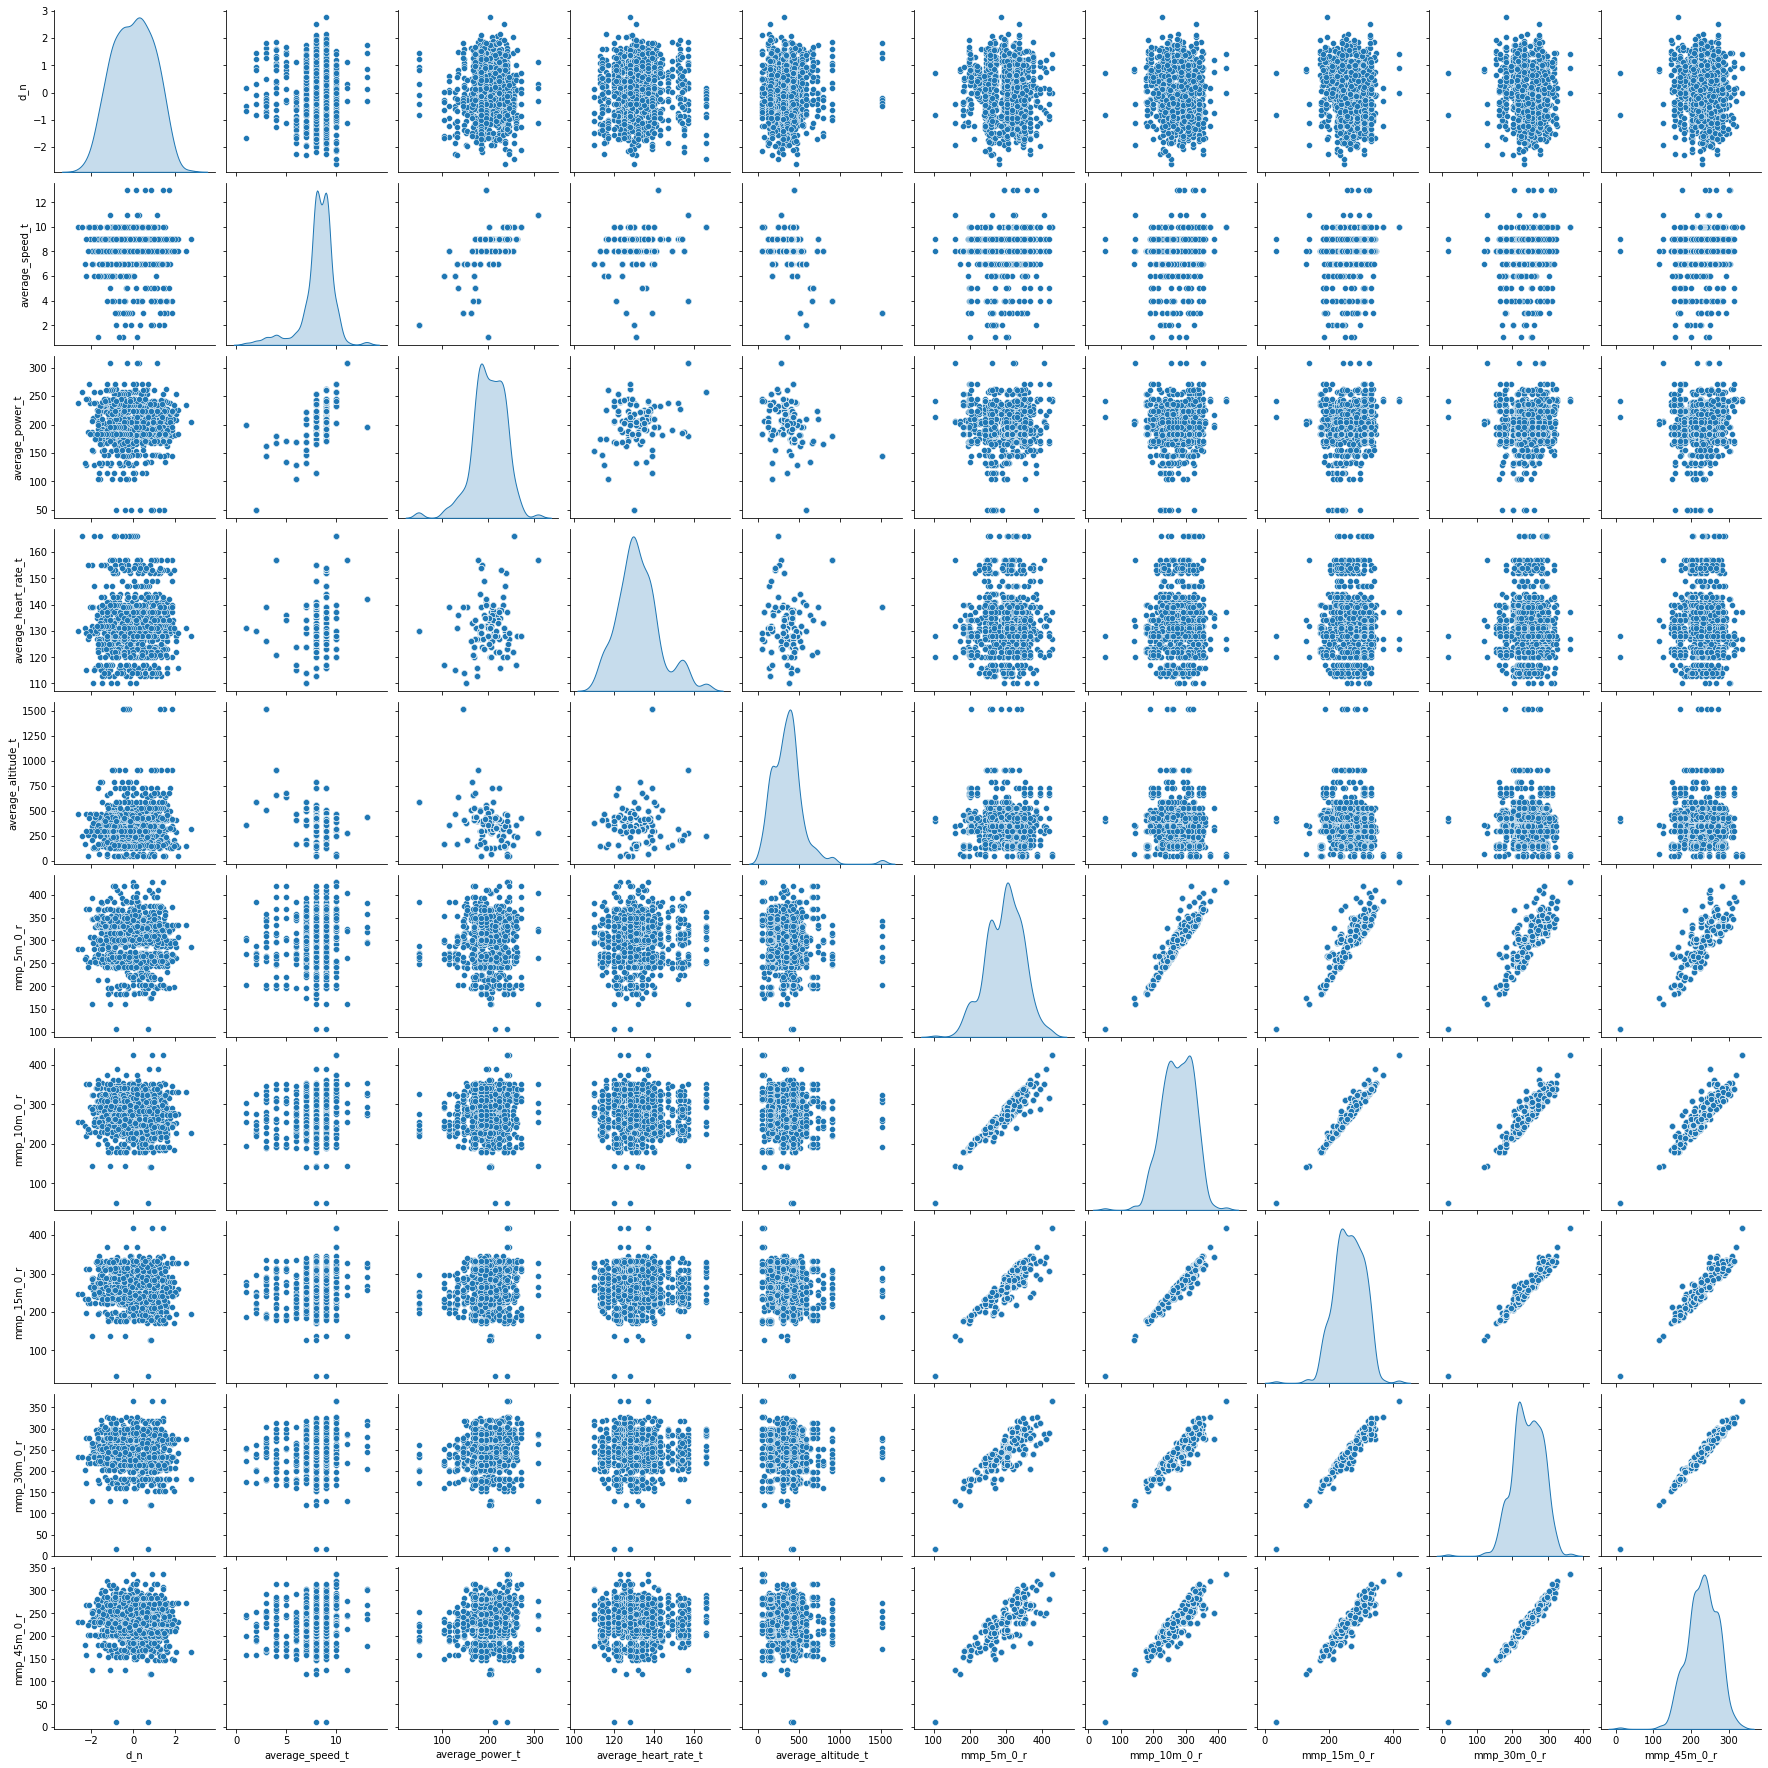

In [72]:
features_subset = features[:5]
all_subset_features = features_subset + predict_targets
plot_subset = df_r[all_subset_features]
sns.pairplot(plot_subset, diag_kind='kde', vars=all_subset_features, x_vars=features_subset, y_vars=predict_targets)

In [73]:
df_r = df_r[df_r['average_power_t']>100]
df_r = df_r[df_r['average_altitude_t']<1200]

In [96]:
len(df_r['cluster'].unique())

26

Function to obtain features for a stepwise regression

In [75]:
def forward_regression(X, y,
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=False):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            # Change argmin -> idxmin
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add   with p-value '.format(best_feature, best_pval))

        if not changed:
            break

    return included

# Set-up the ML models

In [76]:
xgboost_model = XGBRegressor(
            seed=42,
            eta=0.3,
            gamma=16,
            learning_rate=0.5,
            max_depth=8,
            n_estimators=400,
            reg_alpha=0.4,
            reg_lambda=0.6,
            objective='reg:squarederror',
            booster='gbtree')
catboost_model = CatBoostRegressor(learning_rate=0.03, iterations=200, l2_leaf_reg=100, logging_level='Silent')
decision_tree_model = DecisionTreeRegressor(random_state=42)
random_forest_model = RandomForestRegressor(n_estimators=200, random_state=42)
linear_regression_model = LinearRegression(normalize=True)
lasso_regression_model = Lasso(alpha=1)
test_models = {
    'xgboost':{'model':xgboost_model, 'squeeze':False, 'stepwise':False},
    'catboost':{'model':catboost_model, 'squeeze':False, 'stepwise':False},
    'decision_tree':{'model':decision_tree_model, 'squeeze':True, 'stepwise':False},
    'random_forest':{'model':random_forest_model, 'squeeze':True, 'stepwise':False},
    'linear_regression':{'model':linear_regression_model, 'squeeze':True, 'stepwise':False},
#     'linear_regression_stepwise':{'model':linear_regression_model, 'squeeze':True, 'stepwise':True},
    'lasso_regression':{'model':lasso_regression_model, 'squeeze':True, 'stepwise':False}
}

## Functions for cross-validation

In [77]:
def train_model(model, train_df, selected_features, target, squeeze=False):
    train_x = train_df[selected_features]
    train_y = train_df[target]
    if squeeze:
        train_x = train_x.squeeze()
        train_y = train_y.squeeze()
    model.fit(train_x, train_y)
    return model

def get_model_accuracy(model, test_x, test_y, squeeze=False):
    if squeeze:
        test_x = test_x.squeeze()
        test_y = test_y.squeeze()
    df_results = pd.DataFrame({'predicted':model.predict(test_x),'real': test_y})
    df_results['rmae'] = np.abs((df_results['predicted'] - df_results['real'])/df_results['real'])
    mean_mae = df_results['rmae'].mean()
    model_sqrt = sklearn_sqrt(df_results['predicted'],df_results['real'])
#     print(mean_mae, model_sqrt)
    return mean_mae, model_sqrt


def mean(arr):
    if len(arr) > 0:
        return sum(arr)/len(arr)
    return None

# Experiment to find the best subset size

In [78]:
predict_targets = ['mmp_5m_0_r','mmp_10m_0_r','mmp_15m_0_r','mmp_30m_0_r','mmp_45m_0_r']

cluster_ids = df_r['cluster'].unique()

subset_test_results = {}
subset_sizes = range(5,14)
for subset_size in subset_sizes:
    steps = len(cluster_ids) - subset_size
    model = test_models['catboost']['model']
    model_test_results = {}
    print('Subset size {}'.format(subset_size))
    target = predict_targets[0]
    single_test_results = {'sqrt':[],'rmae':[],'training_time':[]}
    for i in range(steps):
        start_time = time.time()
        test_cluster_ids = cluster_ids[i:i+subset_size]
        train_cluster_ids = [x for x in cluster_ids if x not in test_cluster_ids]
        train_df = df_r[df_r['cluster'].isin(train_cluster_ids)][features2+[target]]
        test_df = df_r[df_r['cluster'].isin(test_cluster_ids)][features2+[target]]
        train_x = train_df[features2+[target]]
        trained_model = train_model(model, train_x, features2, target, False)
        test_x = test_df[features2]
        test_y = test_df[target]
        rmae_val, sqrt_val = get_model_accuracy(trained_model, test_x, test_y, False)
        single_test_results['sqrt'].append(sqrt_val)
        single_test_results['rmae'].append(rmae_val)
        single_test_results['training_time'].append(time.time()-start_time)
    model_test_results[target] = {'rmae':mean(single_test_results['rmae']), 
                                  'sqrt':mean(single_test_results['sqrt']),
                                  'rmae_var':np.var(single_test_results['rmae']),
                                  'training_time':mean(single_test_results['training_time'])
                                 }
    print('Target feature: {} RMAE: {}% VAR: {}% time: {}'.format(
        target, 
        round(mean(single_test_results['rmae']*100),2),
         round(model_test_results[target]['rmae_var']*100,2),
        model_test_results[target]['training_time']
    )
         )
    subset_test_results[subset_size] = model_test_results


Subset size 5
Target feature: mmp_5m_0_r RMAE: 0.14% VAR: 0.09% time: 0.23814051491873606
Subset size 6
Target feature: mmp_5m_0_r RMAE: 0.14% VAR: 0.06% time: 0.22678009271621705
Subset size 7
Target feature: mmp_5m_0_r RMAE: 0.14% VAR: 0.04% time: 0.2216613167210629
Subset size 8
Target feature: mmp_5m_0_r RMAE: 0.14% VAR: 0.03% time: 0.22453832626342773
Subset size 9
Target feature: mmp_5m_0_r RMAE: 0.14% VAR: 0.01% time: 0.20887272498186896
Subset size 10
Target feature: mmp_5m_0_r RMAE: 0.14% VAR: 0.01% time: 0.2086140364408493
Subset size 11
Target feature: mmp_5m_0_r RMAE: 0.14% VAR: 0.01% time: 0.20119992891947427
Subset size 12
Target feature: mmp_5m_0_r RMAE: 0.14% VAR: 0.0% time: 0.21954904283796037
Subset size 13
Target feature: mmp_5m_0_r RMAE: 0.14% VAR: 0.0% time: 0.21739251797015852


In [79]:
subset_test_results

{5: {'mmp_5m_0_r': {'rmae': 0.14383786934841108,
   'sqrt': 2500.121940904718,
   'rmae_var': 0.0008579042521575947,
   'training_time': 0.23814051491873606}},
 6: {'mmp_5m_0_r': {'rmae': 0.1414199046158548,
   'sqrt': 2438.4172565472663,
   'rmae_var': 0.0005835845056454184,
   'training_time': 0.22678009271621705}},
 7: {'mmp_5m_0_r': {'rmae': 0.13963014468333004,
   'sqrt': 2378.33392703248,
   'rmae_var': 0.0003979903719983119,
   'training_time': 0.2216613167210629}},
 8: {'mmp_5m_0_r': {'rmae': 0.13894539339711823,
   'sqrt': 2360.3669141297164,
   'rmae_var': 0.0003136418278206737,
   'training_time': 0.22453832626342773}},
 9: {'mmp_5m_0_r': {'rmae': 0.13754321036813444,
   'sqrt': 2309.9045675400007,
   'rmae_var': 0.00013374585164342863,
   'training_time': 0.20887272498186896}},
 10: {'mmp_5m_0_r': {'rmae': 0.13648549428598047,
   'sqrt': 2269.900312882649,
   'rmae_var': 6.627604206210884e-05,
   'training_time': 0.2086140364408493}},
 11: {'mmp_5m_0_r': {'rmae': 0.13659367

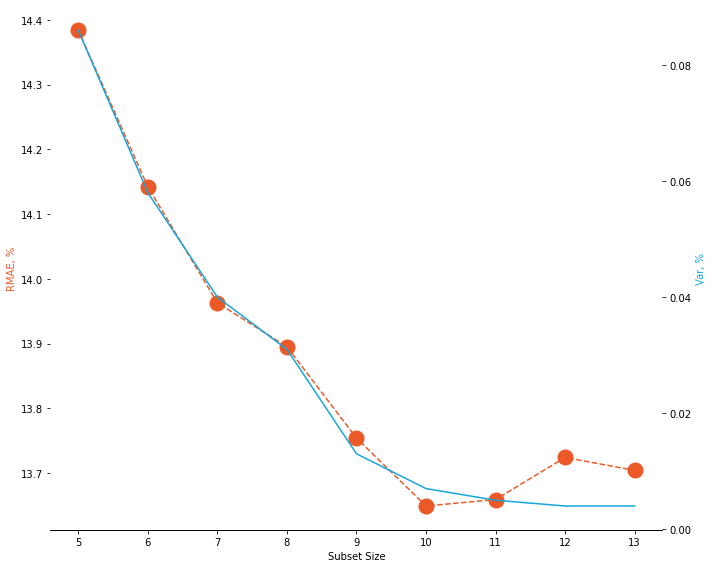

In [80]:

# circle = mpath.Path.unit_circle()
# cut_star = mpath.Path(circle)
fig, ax1 = plt.subplots(figsize=(10,8))

rmae_to_plot = [round(x['mmp_5m_0_r']['rmae']*100,3) for x in subset_test_results.values()]
var_to_plot = [round(x['mmp_5m_0_r']['rmae_var']*100,3) for x in subset_test_results.values()]
# data_to_plot

ax1.set_xlabel('Subset Size')
ax1.set_ylabel('RMAE, %', color='#EA5927')
ax1.plot(subset_sizes, rmae_to_plot, '--r', marker='o', markersize=15, color='#EA5927')
ax2 = ax1.twinx()
ax2.set_ylabel('Var, %', color='#15a6d8')  # we already handled the x-label with ax1
ax2.plot(subset_sizes, var_to_plot, color='#15a6d8')
fig.tight_layout()

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

## Cross-validation experiment

In [81]:
# predict_targets = ['mmp_5m_0_r','mmp_6m_0_r','mmp_10m_0_r','mmp_12m_0_r','mmp_20m_0_r','mmp_30m_0_r','mmp_40m_0_r','mmp_45m_0_r']
predict_targets = ['mmp_5m_0_r','mmp_10m_0_r','mmp_15m_0_r','mmp_30m_0_r','mmp_45m_0_r']

cluster_ids = df_r['cluster'].unique()
subset_size = 10

test_results = {}
steps = len(cluster_ids) - subset_size
for model_name, model_conf in test_models.items():
    model = model_conf['model']
    model_test_results = {}
    print('Model {}'.format(model_name))
    for target in predict_targets:
        single_test_results = {'sqrt':[],'rmae':[],'training_time':[]}
        for i in range(steps):
            start_time = time.time()
            test_cluster_ids = cluster_ids[i:i+subset_size]
            train_cluster_ids = [x for x in cluster_ids if x not in test_cluster_ids]
            train_df = df_r[df_r['cluster'].isin(train_cluster_ids)][features+[target]]
            test_df = df_r[df_r['cluster'].isin(test_cluster_ids)][features+[target]]
            if model_conf['stepwise']:
                selected_features = forward_regression(train_df[features], train_df[target], initial_list=features)
            else:
                selected_features = features2
                
            train_df = train_df[selected_features+[target]]
            test_df = test_df[selected_features+[target]]
            trained_model = train_model(model, train_df, selected_features, target, model_conf['squeeze'])
            test_x = test_df[selected_features]
            test_y = test_df[target]
            rmae_val, sqrt_val = get_model_accuracy(trained_model, test_x, test_y, model_conf['squeeze'])
            single_test_results['sqrt'].append(sqrt_val)
            single_test_results['rmae'].append(rmae_val)
            single_test_results['training_time'].append(time.time()-start_time)
        model_test_results[target] = {'rmae':mean(single_test_results['rmae']), 
                                      'sqrt':mean(single_test_results['sqrt']),
                                  'training_time':mean(single_test_results['training_time'])
                                     }
        print('Target feature: {} RMAE: {}% time:{}'.format(target, round(mean(single_test_results['rmae']),2),round(mean(single_test_results['training_time']),4)))
    test_results[model_name] = model_test_results
    

Model xgboost
Target feature: mmp_5m_0_r RMAE: 0.19% time:0.7529
Target feature: mmp_10m_0_r RMAE: 0.2% time:0.6822
Target feature: mmp_15m_0_r RMAE: 0.19% time:0.6924
Target feature: mmp_30m_0_r RMAE: 0.18% time:0.6751
Target feature: mmp_45m_0_r RMAE: 0.19% time:0.8501
Model catboost
Target feature: mmp_5m_0_r RMAE: 0.14% time:0.2144
Target feature: mmp_10m_0_r RMAE: 0.15% time:0.2044
Target feature: mmp_15m_0_r RMAE: 0.14% time:0.2033
Target feature: mmp_30m_0_r RMAE: 0.14% time:0.206
Target feature: mmp_45m_0_r RMAE: 0.14% time:0.2059
Model decision_tree
Target feature: mmp_5m_0_r RMAE: 0.21% time:0.016
Target feature: mmp_10m_0_r RMAE: 0.23% time:0.0159
Target feature: mmp_15m_0_r RMAE: 0.23% time:0.0179
Target feature: mmp_30m_0_r RMAE: 0.22% time:0.02
Target feature: mmp_45m_0_r RMAE: 0.22% time:0.017
Model random_forest
Target feature: mmp_5m_0_r RMAE: 0.17% time:0.7424
Target feature: mmp_10m_0_r RMAE: 0.18% time:0.687
Target feature: mmp_15m_0_r RMAE: 0.18% time:0.7193
Target

## More specific experiment with CatBoost

In [82]:
exclude_vars = ['average_power_t','mmp_40m_0_t','mmp_45m_0_t','max_altitude_t','average_speed_t']
features2 = [x for x in features if x not in exclude_vars and '_1' not in x]

In [83]:
df_r[features2].corr()

,d_n,average_heart_rate_t,average_altitude_t,high_altitude_distance_t,high_altitude_time_t,total_elevation_t,total_calories_t,total_work_t,bursts_n_t,efforts_20m_t,tempo_efforts_8m_t,mmp_5m_0_t,mmp_6m_0_t,mmp_20m_0_t,mmp_30m_0_t,average_altitude_r,high_altitude_distance_r,total_elevation_r,max_altitude_r
d_n,1.000000,0.030295,0.025119,-0.063876,-0.063876,0.017612,-0.042155,0.013220,0.044708,0.067360,0.088192,0.073074,0.071676,0.063132,0.035002,-0.115821,0.041541,0.121489,-0.119050
average_heart_rate_t,0.030295,1.000000,-0.015191,0.006893,0.006893,0.000147,0.171508,0.071834,0.479008,-0.091184,0.152516,0.249333,0.227190,0.204696,0.231051,-0.069443,-0.023504,0.003557,-0.037048
average_altitude_t,0.025119,-0.015191,1.000000,0.249355,0.249355,0.220504,0.110398,-0.142545,-0.014171,0.136763,0.112956,-0.029073,-0.032515,-0.036147,-0.119396,0.227630,-0.090028,0.020317,0.107165
high_altitude_distance_t,-0.063876,0.006893,0.249355,1.000000,1.000000,-0.025029,0.031196,-0.066668,-0.047376,-0.011198,-0.031736,-0.019104,-0.025732,-0.018651,-0.019622,-0.057359,-0.006634,-0.105077,-0.073972
high_altitude_time_t,-0.063876,0.006893,0.249355,1.000000,1.000000,-0.025029,0.031196,-0.066668,-0.047376,-0.011198,-0.031736,-0.019104,-0.025732,-0.018651,-0.019622,-0.057359,-0.006634,-0.105077,-0.073972
total_elevation_t,0.017612,0.000147,0.220504,-0.025029,-0.025029,1.000000,0.283824,0.673799,0.313448,0.027391,0.106831,0.227431,0.227608,0.285516,0.283255,0.016364,-0.056783,0.149161,-0.007011
total_calories_t,-0.042155,0.171508,0.110398,0.031196,0.031196,0.283824,1.000000,0.249479,-0.052011,-0.056669,0.006586,0.091328,0.075387,0.035998,0.051013,0.052258,-0.010834,0.046602,0.044320
total_work_t,0.013220,0.071834,-0.142545,-0.066668,-0.066668,0.673799,0.249479,1.000000,0.462352,0.004714,0.166770,0.456044,0.470501,0.590114,0.637376,-0.037392,0.027380,-0.000343,-0.024134
bursts_n_t,0.044708,0.479008,-0.014171,-0.047376,-0.047376,0.313448,-0.052011,0.462352,1.000000,0.060417,0.520920,0.417911,0.419033,0.490022,0.509053,-0.087313,-0.056156,0.001219,-0.092298
efforts_20m_t,0.067360,-0.091184,0.136763,-0.011198,-0.011198,0.027391,-0.056669,0.004714,0.060417,1.000000,0.392418,0.157250,0.172443,0.276860,0.024157,-0.021995,-0.008712,-0.060707,-0.032252


In [84]:
target_feature = 'mmp_5m_0_r'

# train_df = df_r[features+[target_feature]]
train_df = df_r.loc[df_r['cluster']<10][features2+[target_feature]]
test_df = df_r[features2+[target_feature]].drop(train_df.index, axis=0)

train_x = train_df[features2]
train_y = train_df[target_feature]
test_x = test_df[features2]
test_y = test_df[target_feature]

model = CatBoostRegressor(model_size_reg=1.5,learning_rate=0.01, iterations=200,depth=7, l2_leaf_reg=175, logging_level='Silent')
model.fit(train_x, train_y)
df_results = pd.DataFrame({'predicted':model.predict(test_x),'real': test_y})
df_results['rmae'] = np.abs((df_results['predicted'] - df_results['real'])/df_results['real'])
df_results['sqrt'] = sklearn_sqrt(df_results['predicted'],df_results['real'])
df_results['rmae'].mean()

0.14950131065763309

In [85]:
df_results = pd.DataFrame({'predicted':model.predict(test_x),'real': test_y})
df_results['rmae'] = np.abs((df_results['predicted'] - df_results['real'])/df_results['real'])
df_results['sqrt'] = sklearn_sqrt(df_results['predicted'],df_results['real'])
df_results['rmae'].mean()

0.14950131065763309

Check the feature importance

In [86]:
list(zip(features,model.get_feature_importance()))

[('d_n', 2.4426101230196346),
 ('average_speed_t', 0.48286034046552745),
 ('average_power_t', 2.0143476060224765),
 ('average_heart_rate_t', 0.0),
 ('average_altitude_t', 0.0),
 ('high_altitude_distance_t', 1.4697577675938138),
 ('high_altitude_time_t', 1.5382119089532515),
 ('total_elevation_t', 1.422179005632519),
 ('total_calories_t', 0.9378360056930143),
 ('total_work_t', 0.0),
 ('max_altitude_t', 0.7708979547079089),
 ('bursts_n_t', 0.9457967394340718),
 ('efforts_20m_t', 1.6701666913155686),
 ('tempo_efforts_8m_t', 1.055745315438467),
 ('mmp_5m_0_t', 1.8019188414372622),
 ('mmp_5m_1_t', 24.470924178246978),
 ('mmp_6m_0_t', 0.0),
 ('mmp_6m_1_t', 45.630903110206816),
 ('mmp_10m_0_t', 13.345844411832678)]

# Data Visualisation

In [87]:
base_model_results = {
'decision_tree': {
  'mmp_5m_0_r': {'rmae': 0.1423},
  'mmp_10m_0_r': {'rmae': 0.1483},
  'mmp_15m_0_r': {'rmae': 0.1744},
  'mmp_30m_0_r': {'rmae': 0.1941},
  'mmp_45m_0_r': {'rmae': 0.21735}
  },
'xgboost': {
  'mmp_5m_0_r': {'rmae': 0.1266},
  'mmp_10m_0_r': {'rmae': 0.1257},
  'mmp_15m_0_r': {'rmae': 0.1341},
  'mmp_30m_0_r': {'rmae': 0.1634},
  'mmp_45m_0_r': {'rmae': 0.185}
  },
'random_forest': {
  'mmp_5m_0_r': {'rmae': 0.118},
  'mmp_10m_0_r': {'rmae': 0.1287},
  'mmp_15m_0_r': {'rmae': 0.1503},
  'mmp_30m_0_r': {'rmae': 0.1711},
  'mmp_45m_0_r': {'rmae': 0.1983}
  },
'linear_regression':{
  'mmp_5m_0_r': {'rmae': 0.1150},
  'mmp_10m_0_r': {'rmae': 0.1187},
  'mmp_15m_0_r': {'rmae': 0.1359},
  'mmp_30m_0_r': {'rmae': 0.1385},
  'mmp_45m_0_r': {'rmae': 0.1683}
  },
'lasso_regression': {
  'mmp_5m_0_r': {'rmae': 0.1088},
  'mmp_10m_0_r': {'rmae': 0.1005},
  'mmp_15m_0_r': {'rmae': 0.1096},
  'mmp_30m_0_r': {'rmae': 0.1101},
  'mmp_45m_0_r': {'rmae': 0.1365}
  },
'catboost': {
  'mmp_5m_0_r': {'rmae': 0.1158},
  'mmp_10m_0_r': {'rmae': 0.1074},
  'mmp_15m_0_r': {'rmae': 0.1164},
  'mmp_30m_0_r': {'rmae': 0.1300},
  'mmp_45m_0_r': {'rmae': 0.1459}
  }
}

In [88]:
test_models_colors = {
    'xgboost':{'new':'#F22300','base':'#ff9380','diff':'#F22300'},
    'catboost':{'new':'#FFCC00','base':'#ffe680','diff':'#FFCC00'},
    'decision_tree':{'new':'#000000','base':'#f39b8c', 'diff':'#F29488'},
    'random_forest':{'new':'#00C9F1','base':'#80eaff', 'diff':'#00C9F1'},
    'linear_regression':{'new':'#BBBBBB','base':'#bfbfbf', 'diff':'#BBBBBB'},
    'lasso_regression':{'new':'#77C4AA','base':'#a6d8c8', 'diff':'#77C4AA'}
}

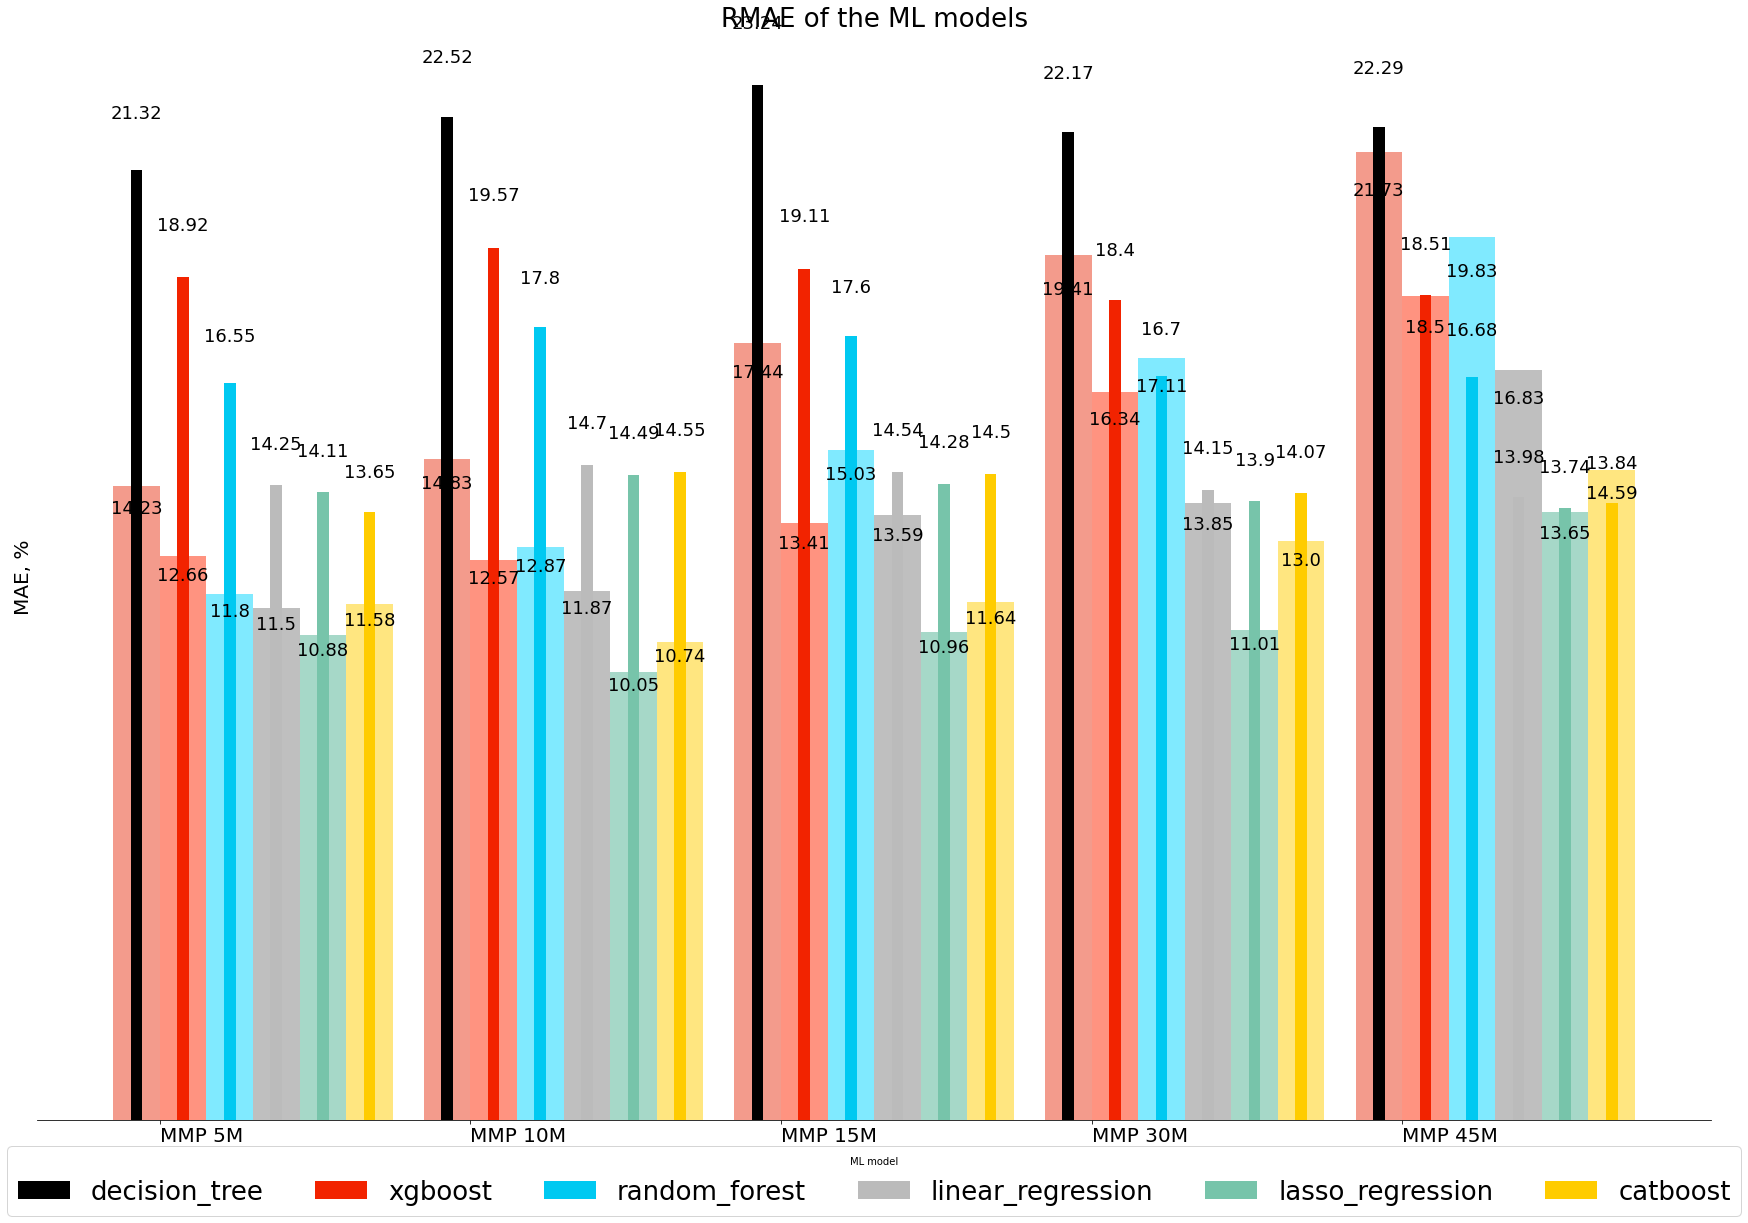

In [89]:

cols_to_compare = ['mmp_5m_0_r','mmp_10m_0_r','mmp_15m_0_r','mmp_30m_0_r','mmp_45m_0_r']
n_categories = len(cols_to_compare)
ind = np.arange(n_categories)
width = 0.15
fig, ax = plt.subplots(figsize=(30,20))
i = 0
def autolabel(rects, data, dec=2):
    """
    Attach a text label above each bar displaying its height
    """
    j = 0
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '{}'.format(round(data[j]*100,dec)),
                ha='center', va='bottom', size=18)
        j += 1
#         r'$\underline{sin(x)}$'

def autolabel_lower(rects, data, dec=2):
    """
    Attach a text label above each bar displaying its height
    """
    j = 0
    for rect in rects:
        height = rect.get_height()
        txt = ax.text(rect.get_x() + rect.get_width()/2., 0.95*height,
                '{}'.format(round(data[j]*100,dec)),
                ha='center', va='bottom', size=18, color='k')
        
#         txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])      
        j += 1
        

rects = []
for model, vals in base_model_results.items():
    data_base = [x['rmae'] for k,x in base_model_results[model].items() if k in cols_to_compare]
    data_new = [x['rmae'] for k,x in test_results[model].items() if k in cols_to_compare]
    bar_base_data = ax.bar(ind + width*i, data_base, width, color=test_models_colors[model]['base'])
    bar_new_data = ax.bar(ind + width*i, data_new, width/4, color=test_models_colors[model]['new'])
    rects.append(bar_new_data)
    autolabel_lower(bar_base_data, data_base)
    autolabel(bar_new_data, data_new)
    i += 1

x_labels = [' '.join(x.split('_')[:2]).upper() for x in cols_to_compare]
ax.set_xticks(ind + width / 2)
ax.set_xticklabels((x_labels), fontsize=20, horizontalalignment='left')

ax.set_yticks([])
ax.set_ylabel('MAE, %', fontsize=20)
ax.set_title('RMAE of the ML models', fontsize=26)


ax.legend((rects), ([model for model, vals in base_model_results.items()]), prop={'size': 26},bbox_to_anchor=(0.5, -0.1), loc='lower center', title='ML model', ncol=len(base_model_results))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# plt.savefig('demo.png', transparent=True)

[0.07090345969720988, 0.07692010166235738, 0.05801199690498021, 0.027632047776597363, 0.005548266538029034]
[0.06261440195203216, 0.06998795692337959, 0.05701966243568757, 0.020607488409055935, 0.0001471868002555221]
[0.04752245511678996, 0.04934364388572801, 0.025690086441556653, -0.004076719573154058, -0.031515098349712]
[0.027547729066656937, 0.02834560097075539, 0.009535675740423133, 0.0030253763393843225, -0.02852468778514436]
[0.032251002853985286, 0.04438145221962764, 0.03319763997935313, 0.028922135241606223, 0.000943492615526148]
[0.020685494285980474, 0.03809347218697462, 0.02855611171997166, 0.010658551317825365, -0.007497440382429638]


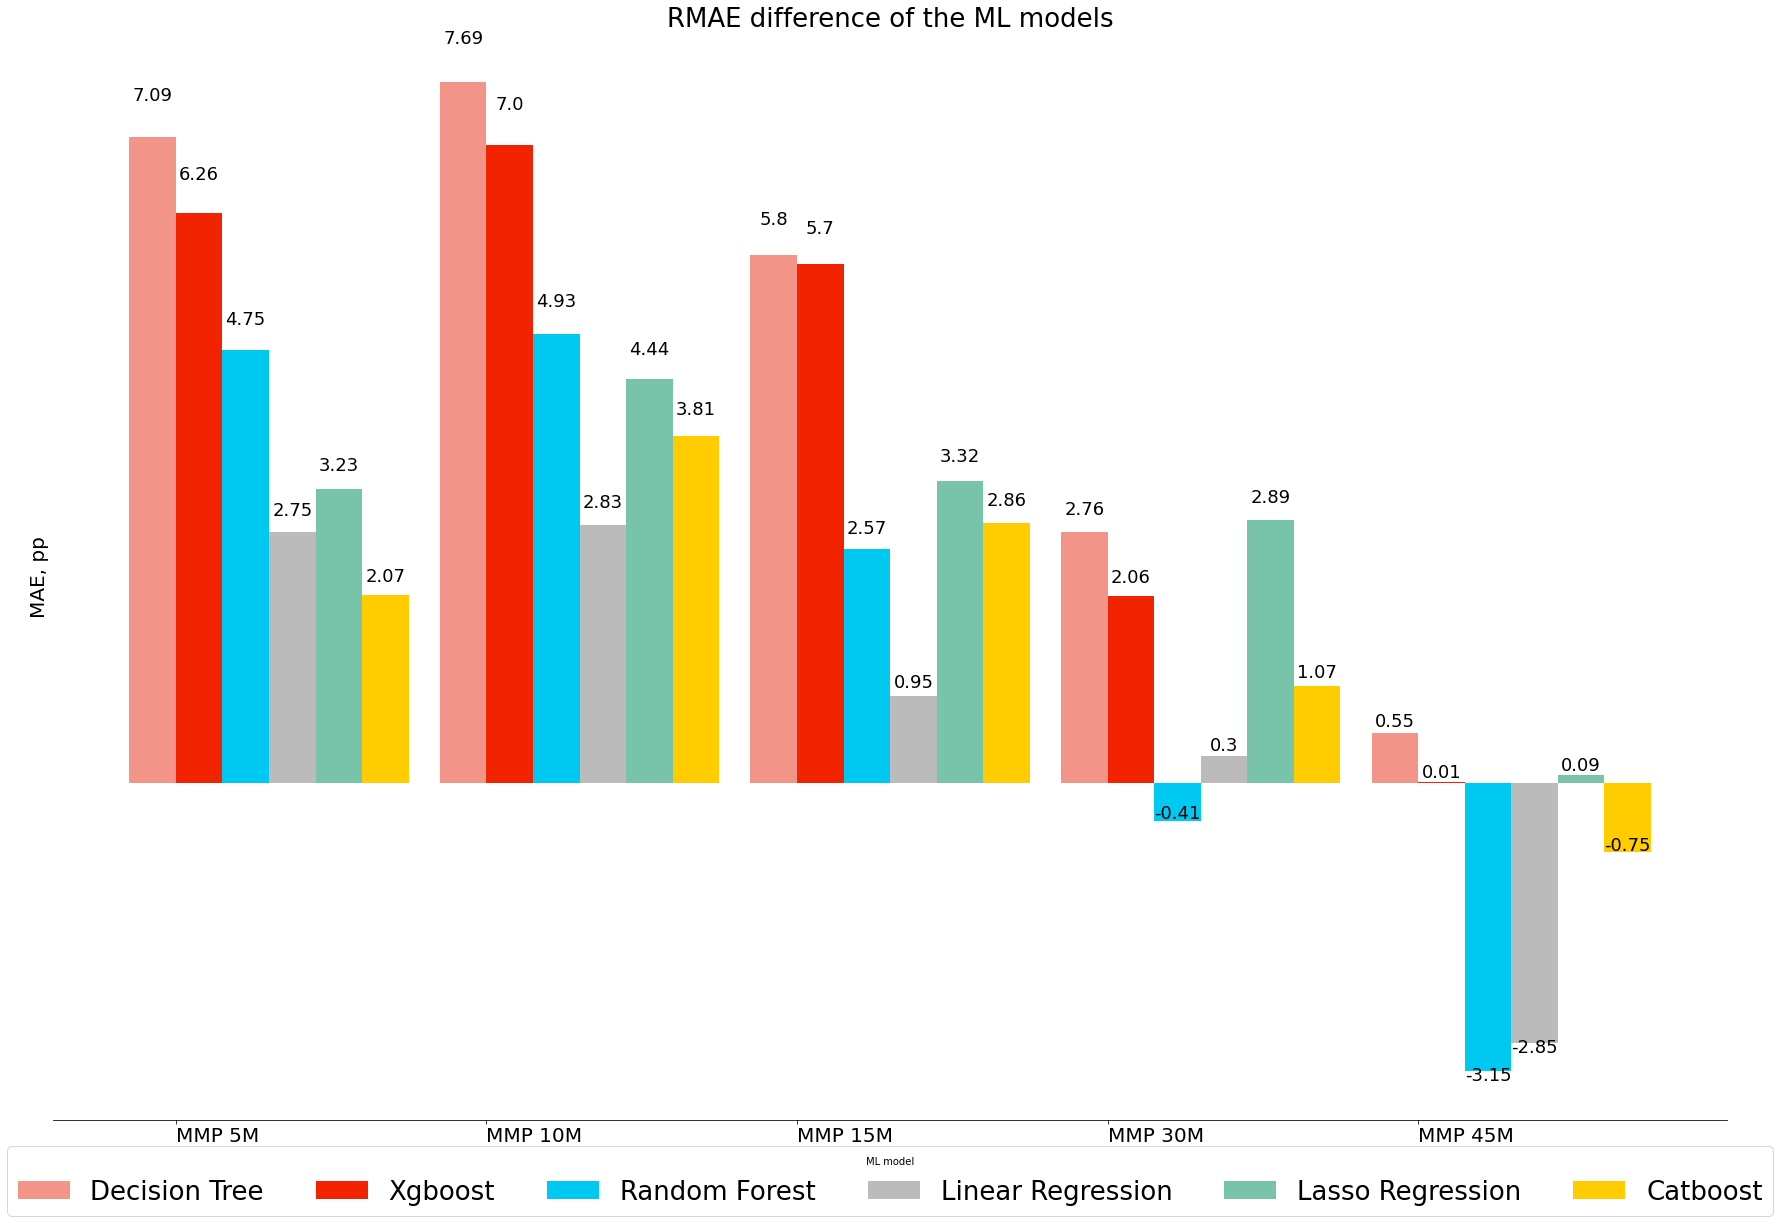

In [90]:

cols_to_compare = ['mmp_5m_0_r','mmp_10m_0_r','mmp_15m_0_r','mmp_30m_0_r','mmp_45m_0_r']
n_categories = len(cols_to_compare)
ind = np.arange(n_categories)
width = 0.15
fig, ax = plt.subplots(figsize=(30,20))
i = 0

rects = []
diffs = {}
for model, vals in base_model_results.items():
    data_base = [x['rmae'] for k,x in base_model_results[model].items() if k in cols_to_compare]
    data_new = [x['rmae'] for k,x in test_results[model].items() if k in cols_to_compare]
    data_diff = [x-y for x,y in zip(data_new,data_base)]
    print(data_diff)
    diffs[model] = data_diff
    bar_base_data = ax.bar(ind + width*i, data_diff, width, color=test_models_colors[model]['diff'])
    rects.append(bar_base_data)
    autolabel(bar_base_data, data_diff)
    i += 1

x_labels = [' '.join(x.split('_')[:2]).upper() for x in cols_to_compare]
ax.set_xticks(ind + width / 2)
ax.set_xticklabels((x_labels), fontsize=20, horizontalalignment='left')

ax.set_yticks([])
ax.set_ylabel('MAE, pp', fontsize=20)
ax.set_title('RMAE difference of the ML models', fontsize=26)

model_names = ['Decision Tree',
 'XGboost',
 'Random Forest Tree',
 'Linear Regression',
 'Lasso Regression',
 'CatBoost']

ax.legend((rects), [model.replace('_',' ').title() for model in base_model_results.keys()], prop={'size': 26},bbox_to_anchor=(0.5, -0.1), loc='lower center', title='ML model', ncol=len(base_model_results))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig('diff.png', transparent=True)

In [97]:
{k:round(sum(d)/len(d)*100,2) for k,d in diffs.items()}

{'decision_tree': 4.78,
 'xgboost': 4.21,
 'random_forest': 1.74,
 'linear_regression': 0.8,
 'lasso_regression': 2.79,
 'catboost': 1.81}

KeyError: 'rmae_var'

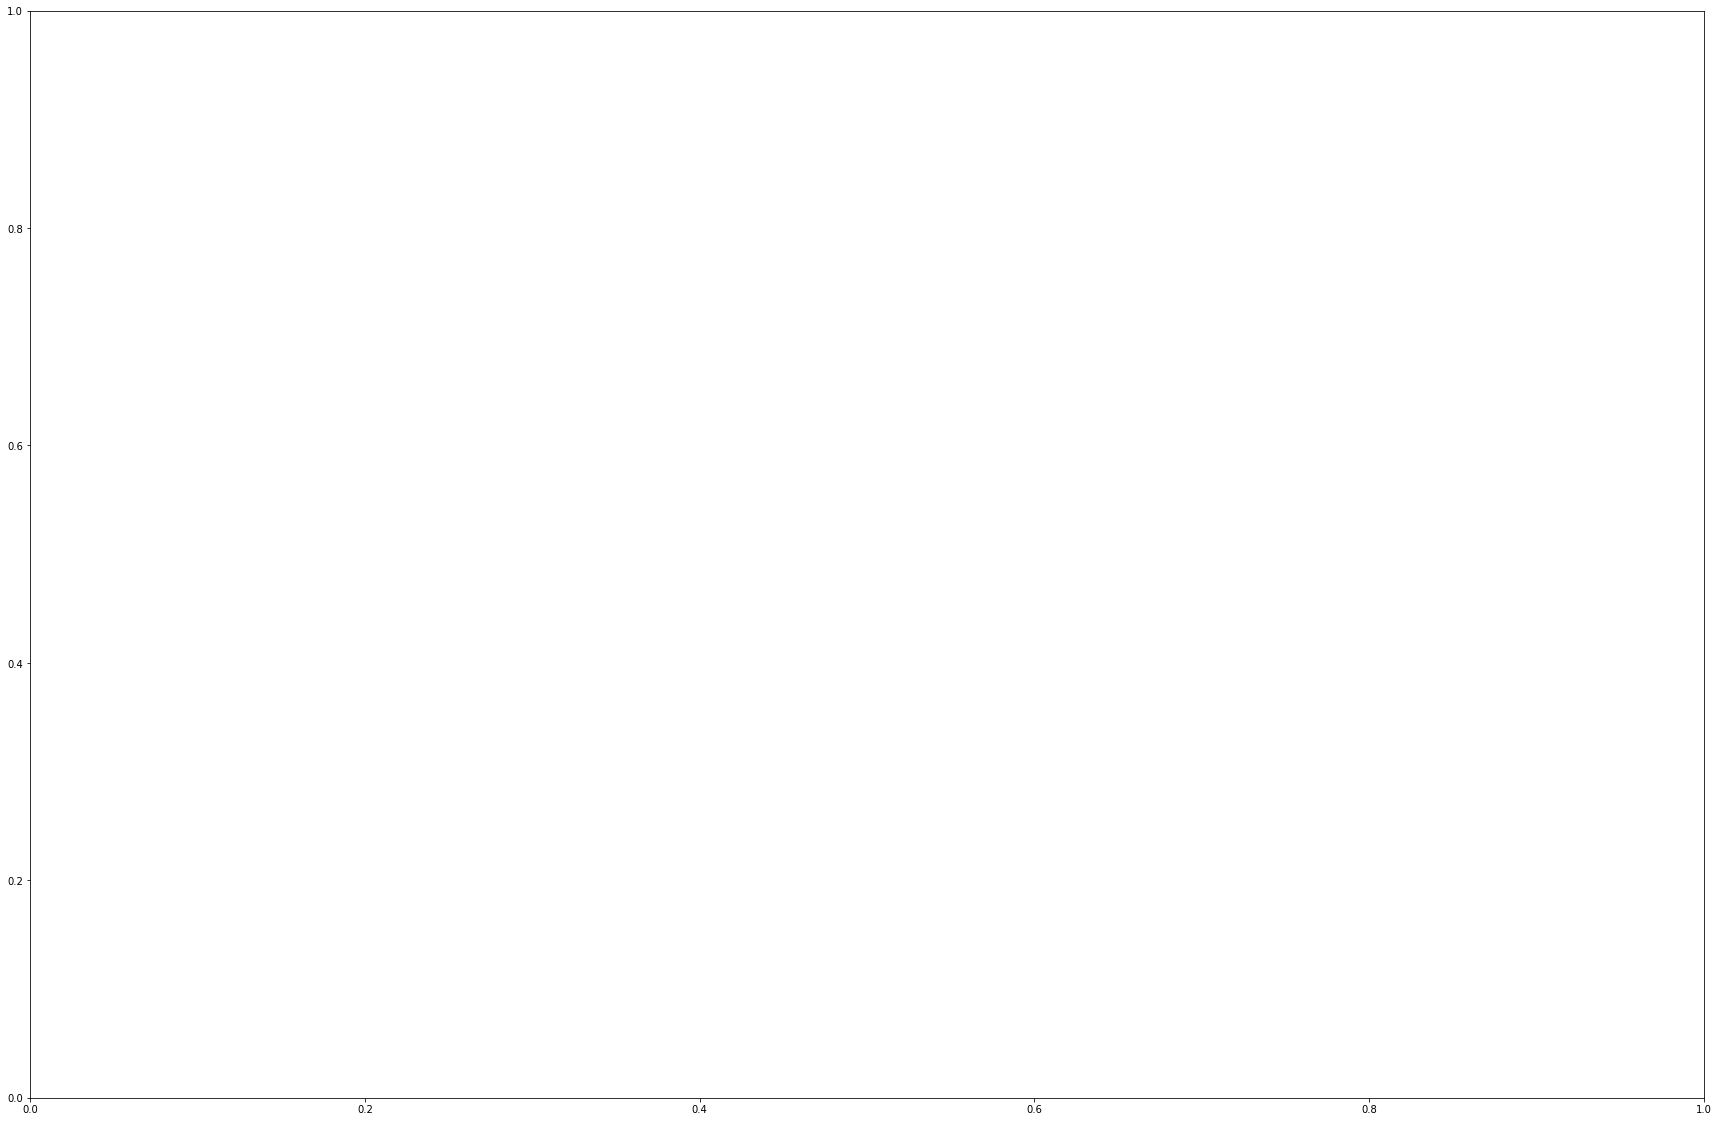

In [92]:

cols_to_compare = ['mmp_5m_0_r','mmp_10m_0_r','mmp_15m_0_r','mmp_30m_0_r','mmp_45m_0_r']
n_categories = len(cols_to_compare)
ind = np.arange(n_categories)
width = 0.15
fig, ax = plt.subplots(figsize=(30,20))
i = 0

rects = []
for model, vals in base_model_results.items():
    data_new = [x['rmae_var'] for k,x in test_results[model].items() if k in cols_to_compare]
    bar_new_data = ax.bar(ind + width*i, data_new, width/4, color=test_models_colors[model]['new'])
    rects.append(bar_new_data)
    autolabel(bar_new_data, data_new, 4)
    i += 1

x_labels = [' '.join(x.split('_')[:2]).upper() for x in cols_to_compare]
ax.set_xticks(ind + width / 2)
ax.set_xticklabels((x_labels), fontsize=20, horizontalalignment='left')

ax.set_yticks([])
ax.set_ylabel('Var, %', fontsize=20)
ax.set_title('Variation by the applied ML model', fontsize=26)


ax.legend((rects), ([model for model, vals in base_model_results.items()]), prop={'size': 26},bbox_to_anchor=(0.5, -0.1), loc='lower center', title='Variation by the applied ML model', ncol=len(base_model_results))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# plt.savefig('demo.png', transparent=True)

In [ ]:

cols_to_compare = ['mmp_5m_0_r','mmp_10m_0_r','mmp_15m_0_r','mmp_30m_0_r','mmp_45m_0_r']
n_categories = len(cols_to_compare)
ind = np.arange(n_categories)
width = 0.15
fig, ax = plt.subplots(figsize=(30,20))
i = 0

rects = []
for model, vals in base_model_results.items():
    data_new = [x['training_time'] for k,x in test_results[model].items() if k in cols_to_compare]
    bar_new_data = ax.bar(ind + width*i, data_new, width/4, color=test_models_colors[model]['new'])
    rects.append(bar_new_data)
    autolabel(bar_new_data, data_new, 2)
    i += 1

x_labels = [' '.join(x.split('_')[:2]).upper() for x in cols_to_compare]
ax.set_xticks(ind + width / 2)
ax.set_xticklabels((x_labels), fontsize=20, horizontalalignment='left')

ax.set_yticks([])
ax.set_ylabel('Time, s', fontsize=20)
ax.set_title('Average training time, s', fontsize=26)


ax.legend((rects), ([model for model, vals in base_model_results.items()]), prop={'size': 26},bbox_to_anchor=(0.5, -0.1), loc='lower center', title='', ncol=len(base_model_results))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# plt.savefig('demo.png', transparent=True)

In [ ]:

# circle = mpath.Path.unit_circle()
# cut_star = mpath.Path(circle)
fig, ax1 = plt.subplots(figsize=(10,8))

rmae_to_plot = [round(x['mmp_5m_0_r']['rmae']*100,3) for x in subset_test_results.values()]
var_to_plot = [round(x['mmp_5m_0_r']['rmae_var']*100,3) for x in subset_test_results.values()]
# data_to_plot

ax1.set_xlabel('Subset Size')
ax1.set_ylabel('RMAE, %', color='#EA5927')
ax1.plot(subset_sizes, rmae_to_plot, '--r', marker='o', markersize=15, color='#EA5927')
ax2 = ax1.twinx()
ax2.set_ylabel('Var, %', color='#15a6d8')  # we already handled the x-label with ax1
ax2.plot(subset_sizes, var_to_plot, color='#15a6d8')
fig.tight_layout()

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

In [ ]:
len(df_r)